intéressant: https://www.scitepress.org/Papers/2018/67520/67520.pdf

mini resnet à la catégorie transfer learning: https://www.tensorflow.org/guide/keras/functional

# I. Librairies

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm_n
import time
import sys

In [2]:
import tensorflow as tf
print('tensorflow version:',tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

tensorflow version: 2.0.0
Num GPUs Available: 1


In [3]:
from generalBDDHandler import GeneralBDDHandler
from generalIOLib import FlatInputDic, GeneralOutputLib
from datasets.BatchGenerator import BatchGenerator

In [4]:
random_seed = 42

## II Batch Generator

In [13]:
loading_batch_size = 20000
test_split = 0.2
validation_split = 0.2
batch_generator = BatchGenerator("datasets/generalIO_v2.csv", loading_batch_size, validation_split, test_split, random_seed )



lines offset reading: 0it [00:00, ?it/s]

lines offset reading: 9993it [00:00, 99434.15it/s]

lines offset reading: 21237it [00:00, 103007.84it/s]

lines offset reading: 33104it [00:00, 107109.88it/s]

lines offset reading: 45787it [00:00, 112349.62it/s]

lines offset reading: 57766it [00:00, 114475.13it/s]

lines offset reading: 71116it [00:00, 119436.55it/s]

lines offset reading: 82008it [00:00, 114419.40it/s]

lines offset reading: 92786it [00:00, 112167.92it/s]

lines offset reading: 104124it [00:00, 112528.77it/s]

lines offset reading: 116148it [00:01, 114579.56it/s]

lines offset reading: 128414it [00:01, 116882.59it/s]

lines offset reading: 139958it [00:01, 115920.43it/s]

lines offset reading: 151451it [00:01, 115444.61it/s]

lines offset reading: 163539it [00:01, 116862.36it/s]

lines offset reading: 175352it [00:01, 117239.66it/s]

lines offset reading: 187770it [00:01, 119068.03it/s]

lines offset reading: 200352it [00:01, 121009.33it/s]

lines offset reading: 212451it 

lines offset reading: 1539897it [00:13, 110961.52it/s]

lines offset reading: 1551006it [00:13, 108393.78it/s]

lines offset reading: 1561868it [00:13, 106239.65it/s]

lines offset reading: 1572517it [00:13, 104592.74it/s]

lines offset reading: 1584075it [00:14, 107655.28it/s]

lines offset reading: 1594880it [00:14, 107140.23it/s]

lines offset reading: 1605853it [00:14, 107903.88it/s]

lines offset reading: 1616844it [00:14, 108497.33it/s]

lines offset reading: 1628379it [00:14, 110460.59it/s]

lines offset reading: 1639445it [00:14, 108895.96it/s]

lines offset reading: 1650354it [00:14, 107187.41it/s]

lines offset reading: 1661092it [00:14, 101612.76it/s]

lines offset reading: 1671327it [00:14, 96915.81it/s] 

lines offset reading: 1682461it [00:15, 100824.36it/s]

lines offset reading: 1693376it [00:15, 103043.87it/s]

lines offset reading: 1704466it [00:15, 105137.27it/s]

lines offset reading: 1715890it [00:15, 107560.11it/s]

lines offset reading: 1726711it [00:15, 106168.6

lines offset reading: 3024119it [00:27, 109394.39it/s]

lines offset reading: 3035092it [00:27, 107395.81it/s]

lines offset reading: 3046688it [00:27, 109681.10it/s]

lines offset reading: 3057691it [00:27, 106905.73it/s]

lines offset reading: 3068421it [00:27, 104982.52it/s]

lines offset reading: 3078955it [00:27, 104932.75it/s]

lines offset reading: 3089854it [00:27, 106116.77it/s]

lines offset reading: 3102048it [00:28, 110410.04it/s]

lines offset reading: 3113730it [00:28, 112103.17it/s]

lines offset reading: 3124988it [00:28, 110755.10it/s]

lines offset reading: 3136101it [00:28, 106408.97it/s]

lines offset reading: 3146805it [00:28, 104412.09it/s]

lines offset reading: 3158330it [00:28, 107293.43it/s]

lines offset reading: 3170659it [00:28, 111487.00it/s]

lines offset reading: 3181893it [00:28, 111741.49it/s]

lines offset reading: 3193125it [00:28, 108667.14it/s]

lines offset reading: 3204051it [00:28, 108030.95it/s]

lines offset reading: 3214896it [00:29, 105480.1

lines offset reading: 4508240it [00:41, 96893.30it/s]

lines offset reading: 4518446it [00:41, 98249.03it/s]

lines offset reading: 4528304it [00:41, 96760.88it/s]

lines offset reading: 4538387it [00:41, 97941.23it/s]

lines offset reading: 4549244it [00:41, 100769.31it/s]

lines offset reading: 4559358it [00:41, 97102.30it/s] 

lines offset reading: 4569123it [00:41, 95273.87it/s]

lines offset reading: 4579609it [00:41, 97959.92it/s]

lines offset reading: 4589864it [00:41, 99149.80it/s]

lines offset reading: 4599819it [00:42, 91219.97it/s]

lines offset reading: 4611514it [00:42, 97665.81it/s]

lines offset reading: 4622909it [00:42, 101898.17it/s]

lines offset reading: 4633311it [00:42, 100452.09it/s]

lines offset reading: 4643522it [00:42, 100943.45it/s]

lines offset reading: 4654237it [00:42, 102723.54it/s]

lines offset reading: 4664593it [00:42, 102670.86it/s]

lines offset reading: 4674919it [00:42, 97597.89it/s] 

lines offset reading: 4684772it [00:42, 97151.54it/s]

li

# III Model

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout,Flatten, Conv2D, Activation, MaxPooling2D,GlobalAveragePooling2D, BatchNormalization,concatenate
from tensorflow.keras.optimizers import Adam

In [15]:
flatInputLib = FlatInputDic()
generalOutputLib = GeneralOutputLib()
def create_MLP_CNN():
    
    mlp_inputs = Input(shape = (7,), name = 'mlp')
    cnn_inputs = Input(shape = (29,15,7), name = 'cnn')
    
    #mlp model
    mlp_core = Dense(16, activation = 'relu')(mlp_inputs)
    mlp_core = Dense(16, activation = 'relu')(mlp_core)
    
    #cnn model
    cnn_core = Conv2D(128, (3, 3), activation='relu', padding = 'same')(cnn_inputs)
    cnn_core = Conv2D(128, (3, 3), activation='relu', padding = 'same')(cnn_core)
    cnn_core = MaxPooling2D((2, 2))(cnn_core)
    cnn_core = Conv2D(256, (3, 3), activation='relu', padding = 'same')(cnn_core)
    cnn_core = Conv2D(256, (3, 3), activation='relu', padding = 'same')(cnn_core)
    cnn_core = MaxPooling2D((2, 2))(cnn_core)
    cnn_core = Conv2D(512, (3, 3), activation='relu', padding = 'same')(cnn_core)
    cnn_core = Conv2D(512, (3, 3), activation='relu', padding = 'same')(cnn_core)
    cnn_core = GlobalAveragePooling2D()(cnn_core)
    
    #assembly
    x = concatenate([mlp_core, cnn_core])
    
    #dense end
    x = Dropout(0.2)(x)
    x = Dense(generalOutputLib.index, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(generalOutputLib.index, activation = 'softmax')(x)
    
    
    #model
    model = Model(inputs = [mlp_inputs, cnn_inputs], outputs = [output])
    
    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn (InputLayer)                [(None, 29, 15, 7)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 29, 15, 128)  8192        cnn[0][0]                        
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 29, 15, 128)  147584      conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 7, 128)   0           conv2d_7[0][0]                   
____________________________________________________________________________________________

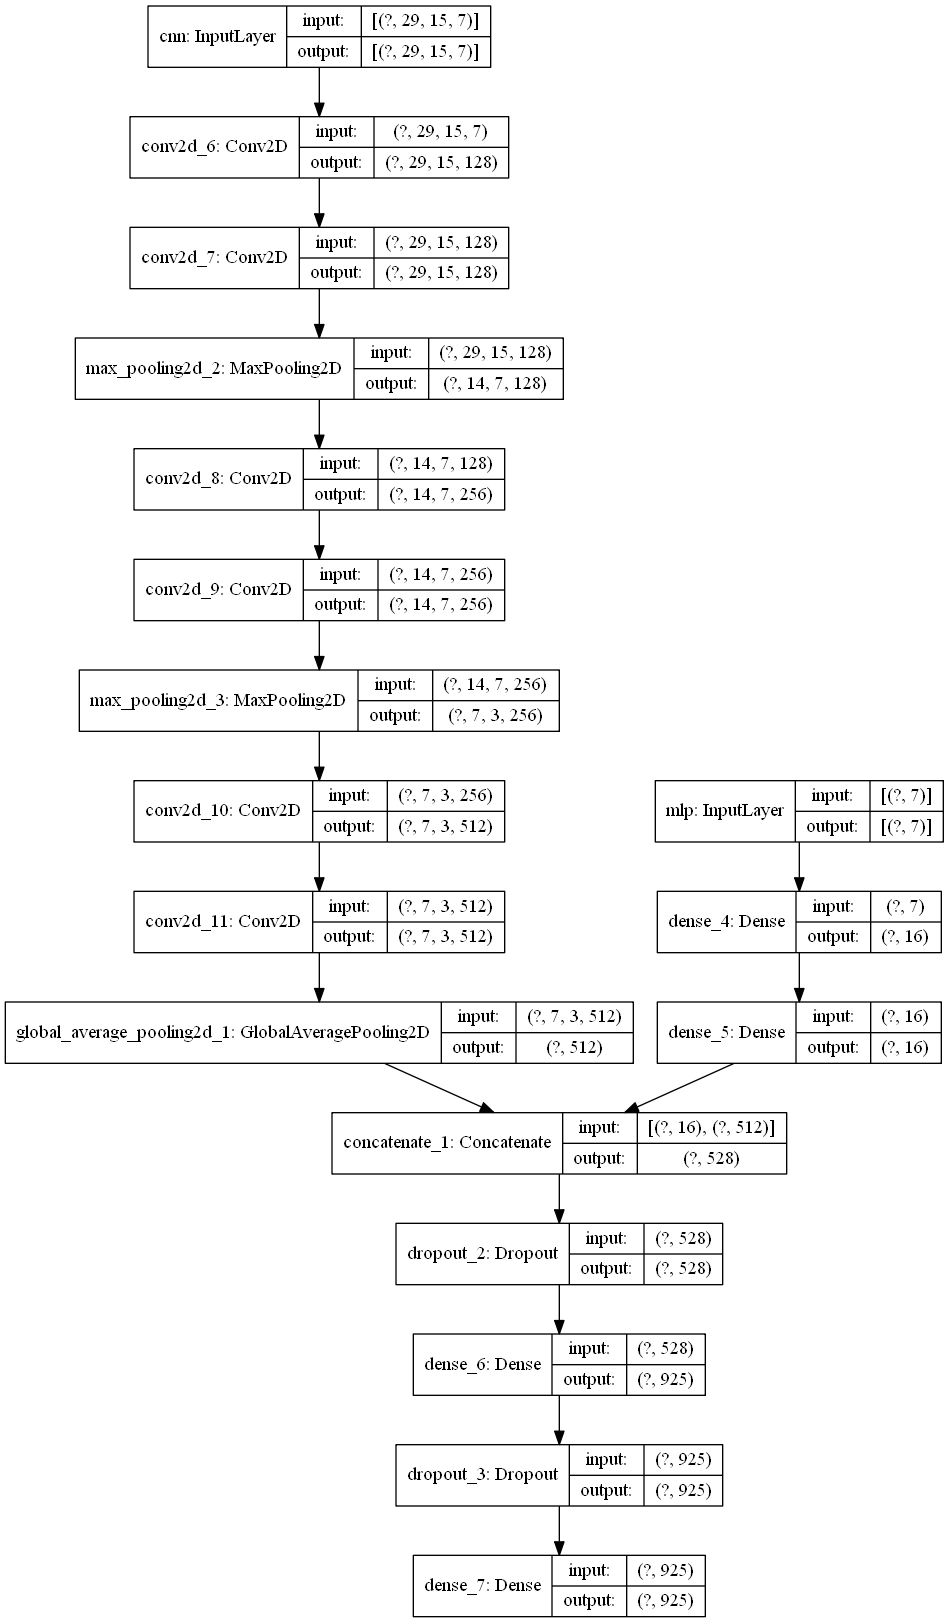

In [16]:
model = create_MLP_CNN()
print(model.summary())
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [17]:
optimizer = Adam() #tf.optimizers.SGD(learning_rate = 1e-3)
model.compile(optimizer=optimizer,loss='categorical_crossentropy')

In [18]:
# define metrics
mean_loss = tf.keras.metrics.Mean(name='train_loss')
categorical_accuracy = tf.keras.metrics.CategoricalAccuracy() 

In [19]:
# define training and evaluation steps
def batchIterator(features, batch_size):
    features_size = features[1].shape[0]
    begin_index = 0
    end_index = 0
    while(end_index != features_size):
        end_index = min(begin_index + batch_size, features_size)
        yield ((features[0][0][begin_index:end_index], features[0][1][begin_index:end_index]), features[1][begin_index:end_index])
        begin_index = end_index


@tf.function
def forward(features, training=False):
    predictions = model.call(features[0], training=training)
    loss = tf.losses.categorical_crossentropy(
            y_true=features[1],
            y_pred=predictions)
    return loss, predictions

@tf.function
def train_step(features):
    with tf.GradientTape() as tape:
        loss, predictions = forward(features, training=True)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    _ = mean_loss.update_state(loss)
    _ = categorical_accuracy.update_state(features[1], predictions)
    accuracy = categorical_accuracy.result()
    return mean_loss.result(), accuracy

def evaluate(features, step):
    loss, predictions = forward(features)
    _ = train_accuracy.update_state(features[1], predictions)
    train_loss(loss)
    template = "step: {} - train loss/acc: {:.3f}/{:2.2%}"
    print(template.format(step,train_loss.result(), train_accuracy.result()))

## V Training

In [20]:
n_training_samples = len(batch_generator.train_index)
n_epochs = 25
bar_position = 1
training_batch_size = 512
pbar1 = tqdm_n(desc="training model", total = n_epochs, position = 0)
for epoch_num in range(n_epochs):
    pbar2 = tqdm_n(desc = f"epoch {epoch_num} training setup ...", total = n_training_samples, position = bar_position)
    for features, infos in batch_generator.getTrainBatches2(loading_batch_size, n_workers = 4):
        for training_batch_features in batchIterator(features, training_batch_size):
            loss, accuracy = train_step(training_batch_features)
            pbar2.set_description(f"epoch {epoch_num}: train loss/acc: {loss:.3f}/{accuracy:2.2%}")
            pbar2.update(training_batch_features[1].shape[0])
    bar_position += 1
    pbar1.update(1)

KeyboardInterrupt: 